In [6]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [7]:
from src.algorithms.vae import VaeAlgo
from src.utils.util import *
from src.dataset.swat import SwatDataset
from src.model.modelvae import *

In [8]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    

04:07:47


<h4>Initializing Dataset</h4>

In [9]:
seed=0
swat = SwatDataset(seed)

In [10]:
x_train, y_train, x_test, y_test = swat.data()

/home/jupyter/GRANOGAN-IISC/src/dataset/swat.py:142: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df: pd.DataFrame = pd.read_csv(self.raw_path_test)
/home/jupyter/GRANOGAN-IISC/src/dataset/swat.py:143: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df: pd.DataFrame = pd.read_csv(self.raw_path_train)


Total Number of anomalies in train set = 0
Total Number of anomalies in test set = 19271
% of anomalies in the test set = 4.6484421169937935
number of anomalous events = 35


In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x_train)
x_train = imputer.transform(x_train)

In [ ]:
reduced_dimesnion=3
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_train)
x_train=pca.transform(x_train)

In [8]:
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_test)
x_test=pca.transform(x_test)

In [11]:
sequences,y_train_per_window = get_sub_seqs(x_train,y_train, seq_len=60, stride=1,
                                 start_discont=np.array([]))

In [12]:
train_loader, train_val_loader = get_train_data_loaders(sequences, batch_size=32,
                                                                splits=[1 - 0.2,
                                                                        0.2], seed=0)

In [13]:
reduced_dimesnion=51
window_length=60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = window_length # sequence length is equal to the window length
in_dim = reduced_dimesnion # input dimension is same as number of feature
n_features=reduced_dimesnion

In [14]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)

In [15]:
embedding_dim=16
vaeAlgo=VaeAlgo(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [16]:
trained_model=vaeAlgo.train_vaeautoencoder(train_loader)

/libraries/Default_env_55760/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch 0: train loss 0.01603322838761541
Epoch 1: train loss 0.005508924518220651
Epoch 2: train loss 0.0034578310778118878
Epoch 3: train loss 0.002775519170451543
Epoch 4: train loss 0.0023558987015035275


In [17]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/vae/swat/autoencoder.pkl'

In [18]:
torch.save(trained_model.module.state_dict(), PATH)

In [19]:
state_dict = torch.load(PATH)
trained_model=VAE(embedding_dim, n_features,device=device)
trained_model=nn.DataParallel(trained_model)
trained_model.to(device)
trained_model=vaeAlgo.load_model(state_dict,trained_model)

<h4>Loading back the saved models</h4>

In [20]:
vaeAlgo.intialize_lstmvaeautoencoder(trained_model)

<h2>Testing for anomaly</h2>


In [21]:
sequences,y_test_per_window = get_sub_seqs(x_test,y_test, seq_len=60, stride=60, start_discont=np.array([]))
test_loader = DataLoader(dataset=sequences, batch_size=1,  num_workers=4,
                                 shuffle=False)

In [22]:
losses=vaeAlgo.predict_loss(test_loader)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

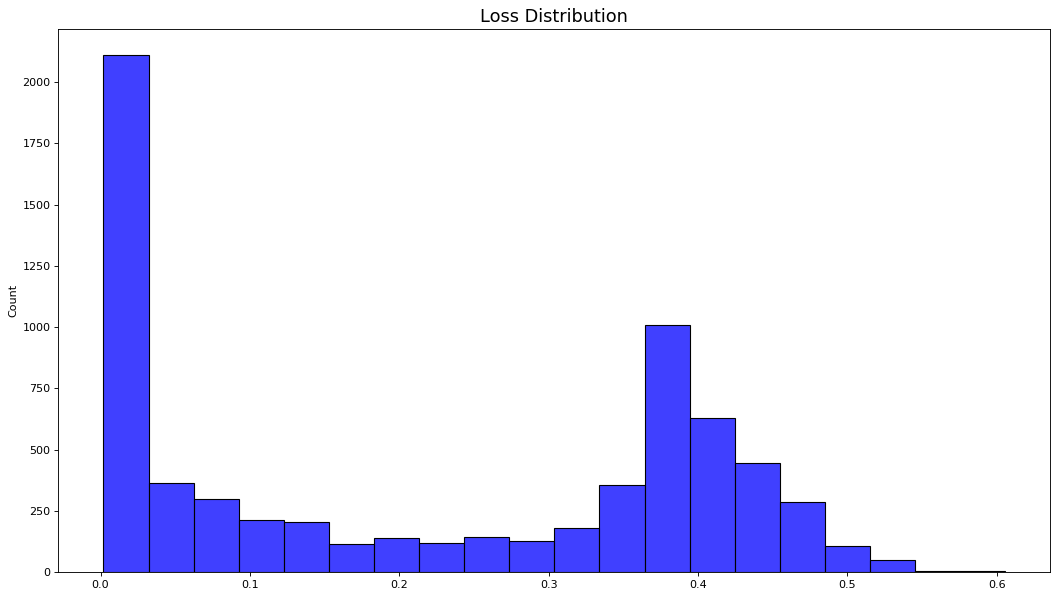

In [24]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

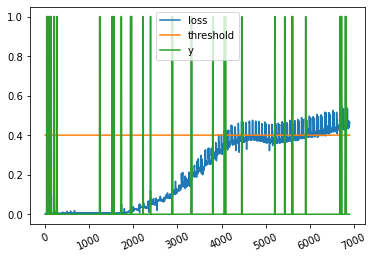

In [38]:
THRESHOLD =0.4
test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss for loss in losses]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

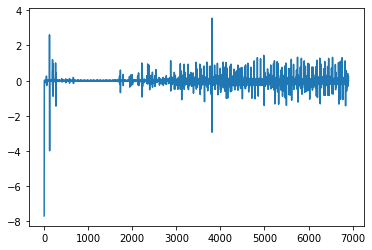

In [39]:
diff = list()
for i in range(0, len(losses)):
    value = losses[i]/60 - losses[i - 1]/60
    diff.append(value*1000)
plt.plot(diff)
plt.show()

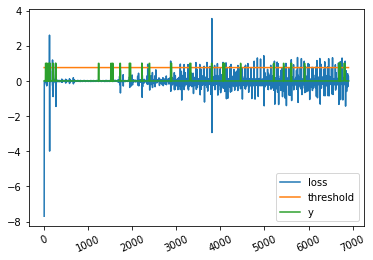

In [58]:
THRESHOLD =0.76

test_score_df = pd.DataFrame(index=range(len(diff)))
test_score_df['loss'] = [loss for loss in diff]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in sequences]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [59]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [60]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 154
True Negative	 6486
False Positive	 66
False Negative	 203
Accuracy	 0.9610652771746997
Precision	 0.7
Recall	 0.43137254901960786
f-measure	 0.533795493934142
cohen_kappa_score	 0.5146720920412606
auc	 0.7106496444731739
roc_auc	 0.7106496444731739
